# D1213_WORK_김현우 
#### 보스턴 집 가격 예측

[1] 모듈 로딩 및 데이터 준비 <HR>

In [345]:
# ===================================================================================================================================
# [1-1] 모듈 로딩
# ===================================================================================================================================

# 분석
import pandas as pd
import numpy as np

# 시각화
import seaborn as sns
import koreanize_matplotlib
import matplotlib.pyplot as plt

# 머신러닝 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report

pd.set_option('mode.copy_on_write', True)
# ===================================================================================================================================
# [1-2] 데이터 준비
# ===================================================================================================================================

FILE_NAME = '../Data/housing.csv'
dataDF = pd.read_csv(FILE_NAME)
houseDF = dataDF.copy()

[2] 이상치 함수 <hr>

In [346]:
# -------------------------------------------------------------
# 이상치 분석 및 선택적 제거
# -------------------------------------------------------------
def analysis_outlier(data, remove=False, target_col=None):
    
    '''
    이상치 분석 및 선택적 제거 함수
    
    data       : DataFrame - 분석할 데이터
    remove     : bool - True: 제거, False: 분석만
    target_col : str - 제거할 열 이름 (remove=True일 때 필수)
    '''
    # 숫자 데이터만 가져옴(error 방지)
    num_data = data.select_dtypes(include=[np.number])
    
    print("=== 이상치 분석 ===")
    for col in num_data.columns:
        
        # 사분위수
        q1, q3 = data[col].quantile([0.25, 0.75])
        iqr = q3 - q1

        # 하한/상한
        lower = q1 - 1.5*iqr
        upper = q3 + 1.5*iqr
        
        # 이상치
        mask = (data[col] < lower) | (data[col] > upper)
        outliers = data[mask][col]
        
        upper_out = data[data[col] > upper][col]
        lower_out = data[data[col] < lower][col]
        
        # 출력
        print(f"【{col}】 범위: [{lower:.2f}, {upper:.2f}]")
        print(f"  이상치: {len(outliers)}개 (상한: {len(upper_out)}, 하한: {len(lower_out)})")
        # if len(outliers) > 0:
        #     print(f"  값: {sorted(outliers.values)}")

        # 제거
        if remove and col == target_col:
            before = len(data)
            cleanDF = data[(data[col] >= lower) & (data[col] <= upper)]
            after = len(cleanDF)
            print(f"  ✓ 제거됨: {before}행 → {after}행")

        print()

    return cleanDF if remove else None

[3] 데이터 확인 및 전처리 <HR>

In [347]:
# ===================================================================================================================================
# 기본 정보 
# ===================================================================================================================================
# MEDV : 주택 중앙값 (단위: $1,000)
# CRIM : 범죄율 (도시별 1인당 범죄율)
# ZN : 25,000 sq.ft. 이상 주택지 비율 (대형 주택 지역 비율)

# ===================================================================================================================================
# 토지 및 산업 특징 
# ===================================================================================================================================
# INDUS : 비소매 상업지 비율 (도시별 비소매 사업 면적 비율)
# CHAS : 찰스 강 인접 여부 (더미 변수: 1=강 인접, 0=비인접)

# ===================================================================================================================================
# 환경 및 위치 특징
# ===================================================================================================================================
# NOX : 질소산화물 농도 (백만 분의 몇 단위)
# DIS : 보스턴 5개 주요 고용센터까지의 가중 거리
# RAD : 방사형 고속도로 접근성 지수

# ===================================================================================================================================
# 주택 특징 
# ===================================================================================================================================
# RM : 주택당 평균 방의 수
# AGE : 1940년 이전 건설 주택 비율 (노후 주택 비율)

# ===================================================================================================================================
# 교육 및 세금 특징 
# ===================================================================================================================================
# TAX : 재산세율 ($10,000 당 세율)
# PTRATIO : 도시별 학생-교사 비율

# ===================================================================================================================================
# 인구 통계 특징 
# ===================================================================================================================================
# B : 흑인 인구 비율 함수 [1000(Bk - 0.63)^2, Bk = 흑인 비율]
# LSTAT : 저소득층 인구 비율 (%)

In [348]:
# ===================================================================================================================================
# [3-1] 데이터 확인 - 모든 컬럼들이 범주형
# ===================================================================================================================================
# 전체 데이터 확인
display(houseDF.head(3))

# 데이터 타입 확인
print(houseDF.info())    # 모든 컬럼들이 범주형 데이터   

# MEDV 컬럼 확인
print(houseDF["MEDV"].value_counts())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB
None
MEDV
50.0    16
25.0     8
23.1     7
22.0     7
21.7     7
        ..
12.6     1
16.4     1
17.7     1
12.0     1
8.1      1
Name: count, Length: 229, dtype: int64


In [349]:
# ===================================================================================================================================
# [3-2] 데이터 전처리
# ===================================================================================================================================
# 중복값, 결측치 확인
print(f"중복값 : {houseDF.duplicated().sum()}\n")    # 중복값 X
print(f"결측치 : {houseDF.isnull().sum().sum()}\n")  # 결측치 X

중복값 : 0

결측치 : 0



[4] 인코딩 <hr>
모두 수치형 변수, 더미변수로 잘 표현되어 있어 인코딩 필요하지 않다고 생각


[5] 피쳐(x)와 타겟(y) 분리 <hr>

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: MEDV, Length: 506, dtype: float64

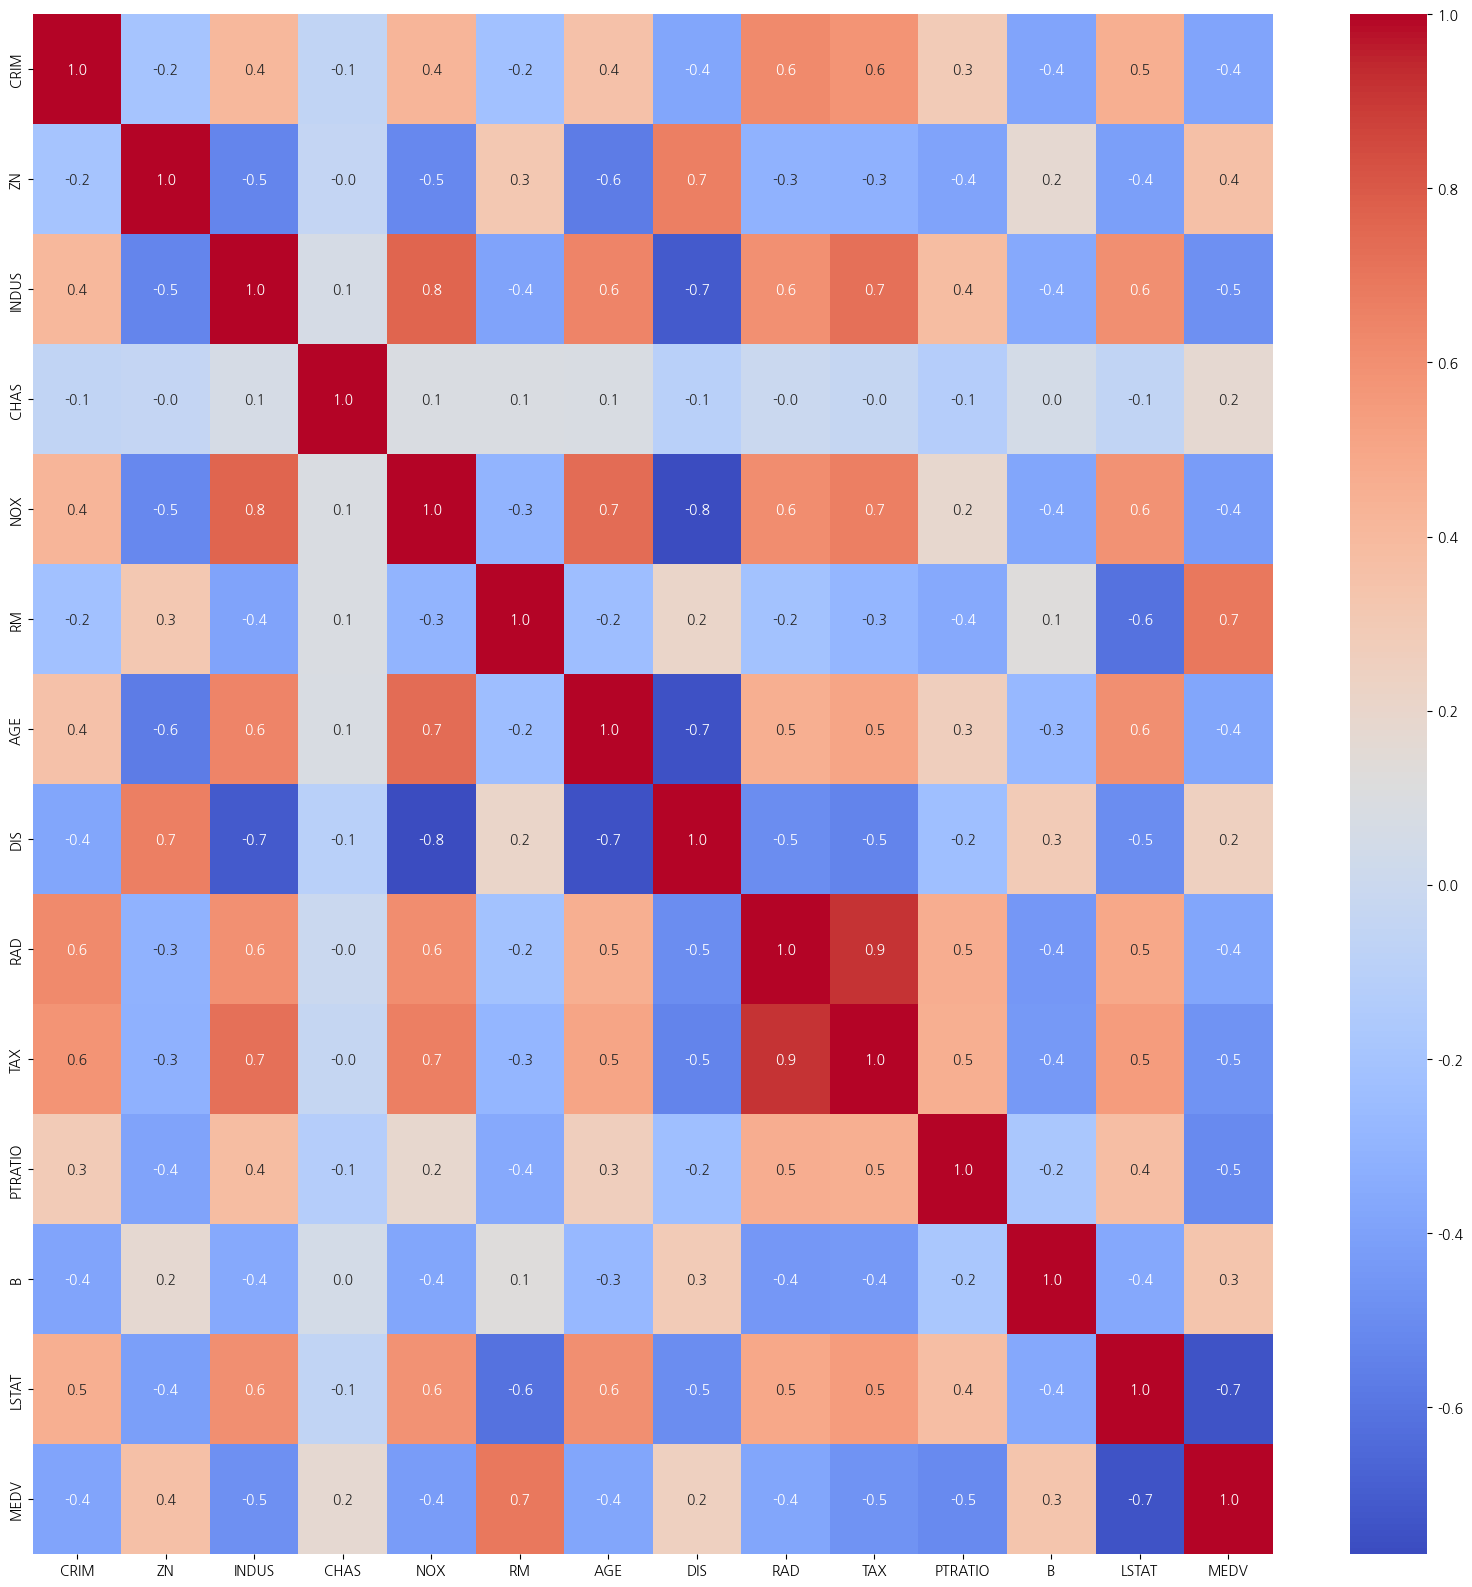

CRIM       0.388305
ZN         0.360445
INDUS      0.483725
CHAS       0.175260
NOX        0.427321
RM         0.695360
AGE        0.376955
DIS        0.249929
RAD        0.381626
TAX        0.468536
PTRATIO    0.507787
B          0.333461
LSTAT      0.737663
MEDV       1.000000
Name: MEDV, dtype: float64
['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


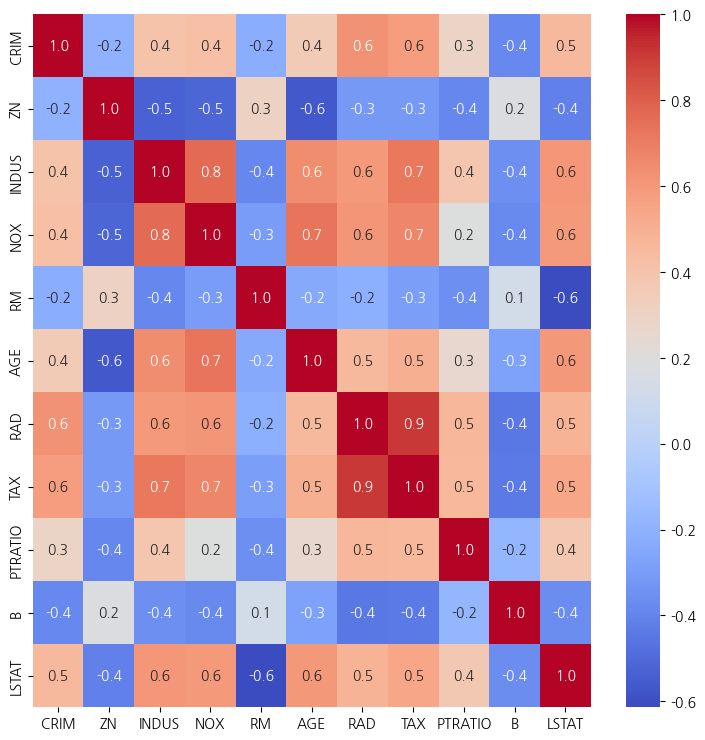

,CRIM,ZN,INDUS,NOX,RM,AGE,TAX,PTRATIO,LSTAT
0,0.00632,18.0,2.31,0.538,6.575,65.2,296.0,15.3,4.98
1,0.02731,0.0,7.07,0.469,6.421,78.9,242.0,17.8,9.14
2,0.02729,0.0,7.07,0.469,7.185,61.1,242.0,17.8,4.03
3,0.03237,0.0,2.18,0.458,6.998,45.8,222.0,18.7,2.94
4,0.06905,0.0,2.18,0.458,7.147,54.2,222.0,18.7,5.33
...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.573,6.593,69.1,273.0,21.0,9.67
502,0.04527,0.0,11.93,0.573,6.120,76.7,273.0,21.0,9.08
503,0.06076,0.0,11.93,0.573,6.976,91.0,273.0,21.0,5.64
504,0.10959,0.0,11.93,0.573,6.794,89.3,273.0,21.0,6.48


In [ ]:
# ===================================================================================================================================
# [5-1] 타겟 분리 - 타겟은 MEDV 컬럼
# ===================================================================================================================================

targetSR = houseDF['MEDV']
display(targetSR)

# ===================================================================================================================================
# [5-2] 상관관계 분석
# ===================================================================================================================================

# ======= 히트맵으로 상관관계 보기 =======
corr_matrix = houseDF.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt='.1f', cmap='coolwarm')
plt.show()


# ======= 타겟 컬럼과 상관계수 절대값이 0.3 이상인 컬럼 이름만 뽑기 =======
corr_ = corr_matrix['MEDV'].abs()
print(corr_)

highCorr = corr_[corr_ >= 0.3].index.tolist()

if 'MEDV' in highCorr:
    highCorr.remove('MEDV')

print(highCorr)

# ======= 0.3 이상인 컬럼들끼리 상관계수 분석 =======
corrDF = houseDF[['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]
corr_matrix2 = corrDF.corr()

plt.figure(figsize=(9, 9))
sns.heatmap(corr_matrix2, annot=True, fmt='.1f', cmap='coolwarm')
plt.show()

# ======= 상관계수 분석 결과 =======
# RAD와 TAX 이 두 컬럼은 서로 상관계수가 0.9
# 따라서 타겟 컬럼과 상관계수 절대값이 더 큰 TAX를 사용하기로 함
# 흑인 인구 비율은 인종 차별적 요소가 있는 거 같아서 배제

# ===================================================================================================================================
# [5-3] 피쳐 분리
# ===================================================================================================================================

featureDF = houseDF[['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'TAX', 'PTRATIO', 'LSTAT']]
display(featureDF)

# ===================================================================================================================================

[6] 피쳐 컬럼 이상치 처리 및 스케일링 <hr>

=== 이상치 분석 ===
【CRIM】 범위: [-5.31, 9.07]
  이상치: 66개 (상한: 66, 하한: 0)

【ZN】 범위: [-18.75, 31.25]
  이상치: 68개 (상한: 68, 하한: 0)

【INDUS】 범위: [-14.18, 37.47]
  이상치: 0개 (상한: 0, 하한: 0)

【NOX】 범위: [0.19, 0.89]
  이상치: 0개 (상한: 0, 하한: 0)

【RM】 범위: [4.78, 7.73]
  이상치: 30개 (상한: 22, 하한: 8)

【AGE】 범위: [-28.55, 167.65]
  이상치: 0개 (상한: 0, 하한: 0)

【TAX】 범위: [-301.50, 1246.50]
  이상치: 0개 (상한: 0, 하한: 0)

【PTRATIO】 범위: [13.20, 24.40]
  이상치: 15개 (상한: 0, 하한: 15)

【LSTAT】 범위: [-8.06, 31.96]
  이상치: 7개 (상한: 7, 하한: 0)



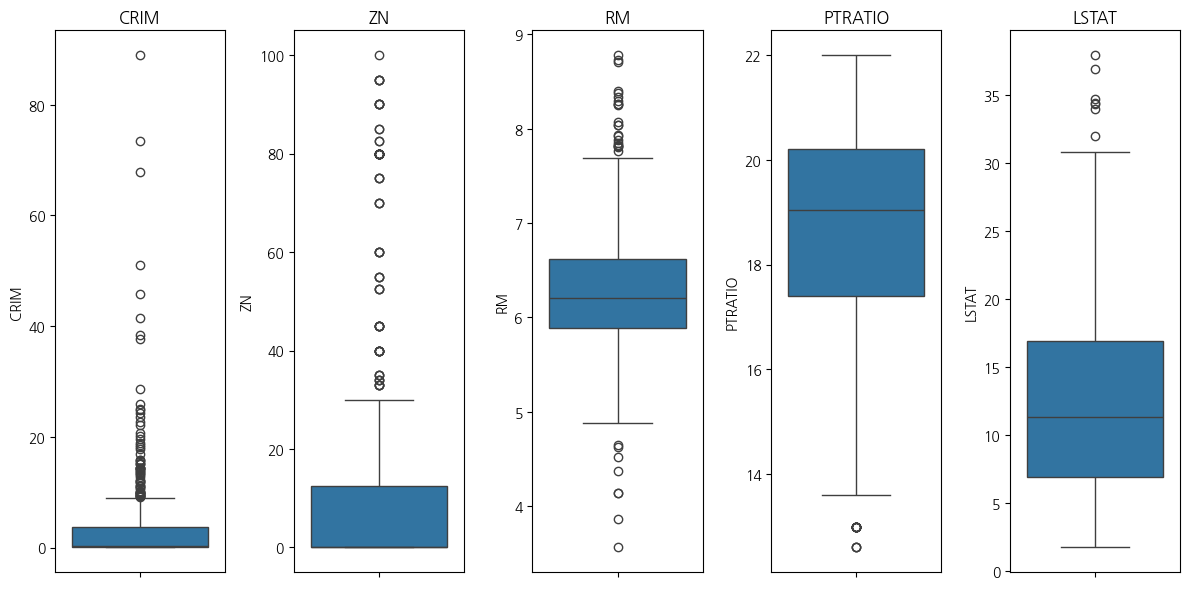

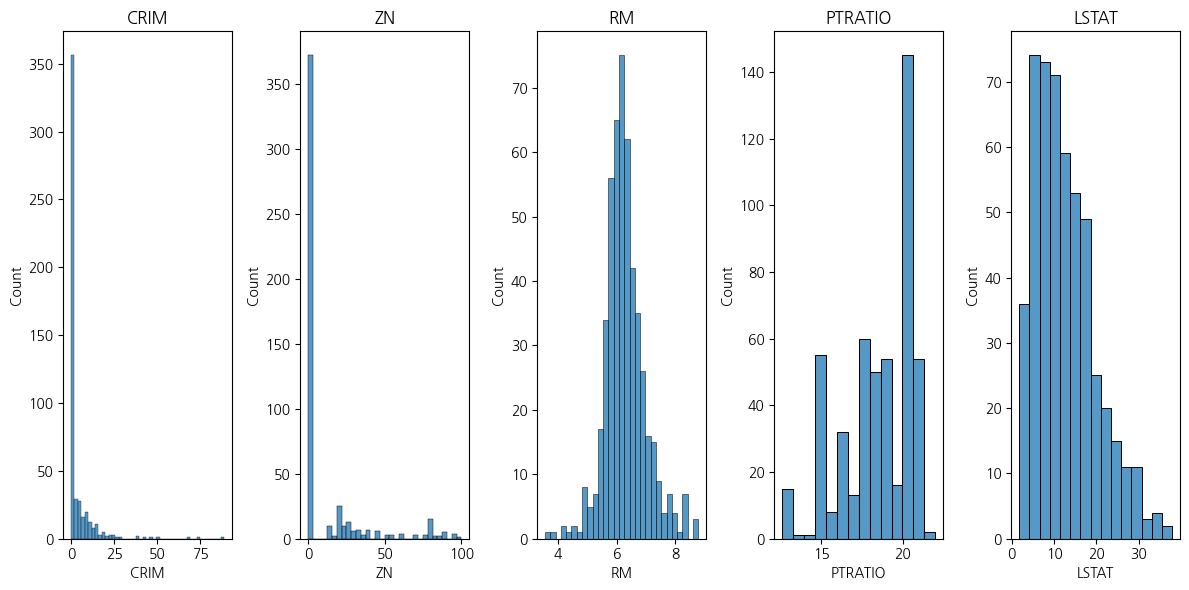

In [351]:
# ===================================================================================================================================
# [6-1] 이상치 확인
# ===================================================================================================================================
analysis_outlier(featureDF)

# ===================================================================================================================================
# [6-2] 이상치 있는 컬럼만 시각화(boxplot, histogram)
# ===================================================================================================================================
outlierDF = featureDF[["CRIM", "ZN", "RM", "PTRATIO", "LSTAT"]]

fig, axes = plt.subplots(1, 5, figsize=(12, 6))
axes = axes.flatten()  

for i in range(len(outlierDF.columns)):
    sns.boxplot(data=outlierDF.iloc[:, i], ax=axes[i])  
    axes[i].set_title(outlierDF.columns[i])

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(12, 6))
axes = axes.flatten()  

for i in range(len(outlierDF.columns)):
    sns.histplot(data=outlierDF.iloc[:, i], ax=axes[i])  
    axes[i].set_title(outlierDF.columns[i])

plt.tight_layout()
plt.show()

=== 이상치 분석 ===
【CRIM】 범위: [-2.12, 3.74]
  이상치: 6개 (상한: 6, 하한: 0)

【ZN】 범위: [-3.90, 6.51]
  이상치: 0개 (상한: 0, 하한: 0)

【INDUS】 범위: [-14.18, 37.47]
  이상치: 0개 (상한: 0, 하한: 0)

【NOX】 범위: [0.19, 0.89]
  이상치: 0개 (상한: 0, 하한: 0)

【RM】 범위: [4.78, 7.73]
  이상치: 0개 (상한: 0, 하한: 0)

【AGE】 범위: [-28.55, 167.65]
  이상치: 0개 (상한: 0, 하한: 0)

【TAX】 범위: [-301.50, 1246.50]
  이상치: 0개 (상한: 0, 하한: 0)

【PTRATIO】 범위: [13.20, 24.40]
  이상치: 0개 (상한: 0, 하한: 0)

【LSTAT】 범위: [-8.06, 31.96]
  이상치: 0개 (상한: 0, 하한: 0)



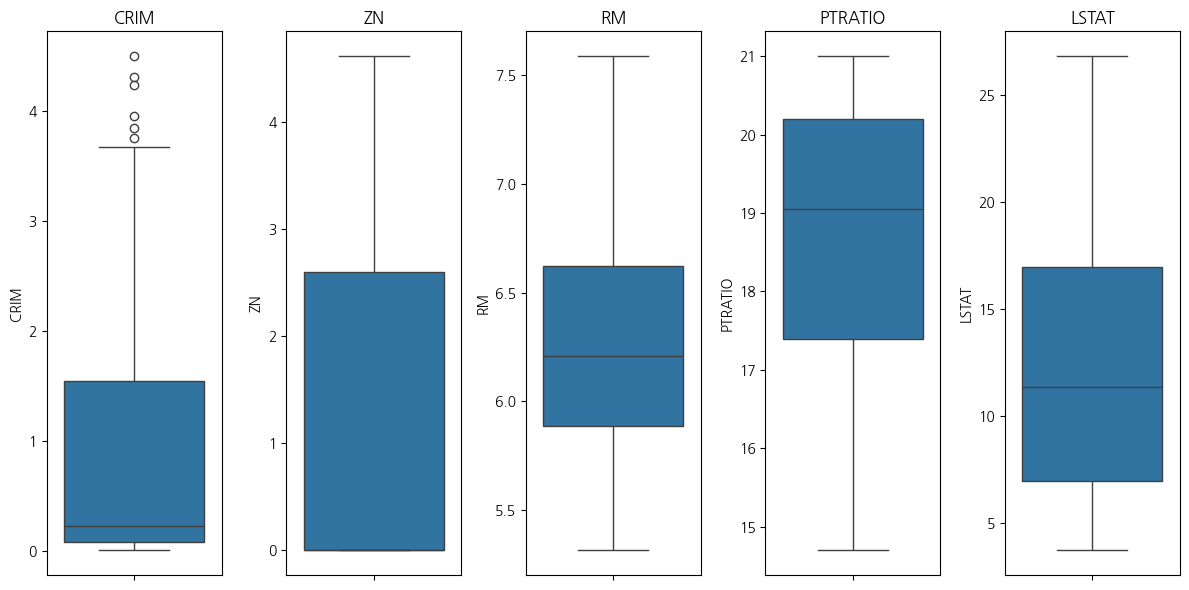

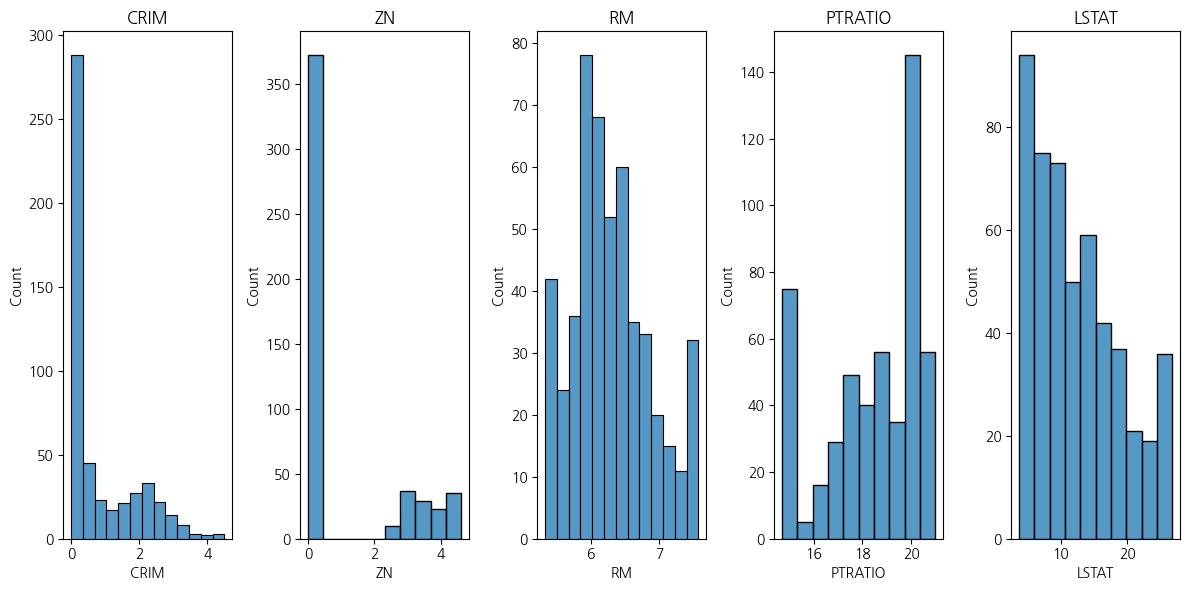

In [352]:
# ===================================================================================================================================
# [6-3] 이상치 처리
# ===================================================================================================================================
# - Winsorizing(윈저화, 상위 OR 하위 5%로 대체)
# RM(방 개수)              - 극단값들로 인한 과적합 방지(현실적이긴 한데 극단적임)
# PTRATIO(학생-교사 비율)   - 특수값 무시하기 위해(적은 비율)
# LSTAT(저소득층 비율)      - 음수값들이 존재 → 노이즈값 제거(현실적인 범위로 재설정)

# - 로그 변환
# ZN(대형 주택 지역 비율)    - 0 많고 양의 왜도(오른쪽 꼬리)
# CRIM(범죄율)             - 양의 왜도(오른쪽 꼬리)
# ===================================================================================================================================

# 로그변환 대상 
logCol = ['CRIM', 'ZN']

for col in logCol:
    featureDF[col] = np.log1p(featureDF[col])

# Winsorizing 대상
capCol = ['RM', 'PTRATIO', 'LSTAT']

for col in capCol:
    lower = featureDF[col].quantile(0.05)
    upper = featureDF[col].quantile(0.95)
    
    featureDF[col] = featureDF[col].clip(lower, upper)
analysis_outlier(featureDF)
# ===================================================================================================================================

outlierDF = featureDF[["CRIM", "ZN", "RM", "PTRATIO", "LSTAT"]]
fig, axes = plt.subplots(1, 5, figsize=(12, 6))
axes = axes.flatten()  

for i in range(len(outlierDF.columns)):
    sns.boxplot(data=outlierDF.iloc[:, i], ax=axes[i])  
    axes[i].set_title(outlierDF.columns[i])

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(12, 6))
axes = axes.flatten()  

for i in range(len(outlierDF.columns)):
    sns.histplot(data=outlierDF.iloc[:, i], ax=axes[i])  
    axes[i].set_title(outlierDF.columns[i])

plt.tight_layout()
plt.show()

[7] 학습용 / 테스트용 데이터셋 분할 <hr>
(x: feature, y: target)

In [353]:
x_train, x_test, y_train, y_test = train_test_split(
    featureDF,
    targetSR,
    random_state=42,
    test_size=0.2)

print(f'[TRAIN] x_train:{x_train.shape},  y_train:{y_train.shape}')
print(f'[TEST]  x_test:{x_test.shape} ,  y_test:{y_test.shape}')

[TRAIN] x_train:(404, 9),  y_train:(404,)
[TEST]  x_test:(102, 9) ,  y_test:(102,)


[7] 배깅 - 랜덤포레스트 모델 생성 및 학습, 비교<hr>

In [354]:
# ===================================================================================================================================
# 1. 초기모델 생성 
# ===================================================================================================================================
rfModel = RandomForestRegressor(
    n_estimators=100,           # 나무 개수 (기본값)
    max_depth=None,             # 최대 깊이 (제한 없음 - 기본값)
    min_samples_split=2,        # 분할 최소 샘플
    min_samples_leaf=1,         # 리프 노드 최소 샘플
    random_state=42,            # 재현성
    n_jobs=-1                   # 병렬 처리 (모든 CPU 코어)
)

# ===================================================================================================================================
# 2. 초기모델 학습
# ===================================================================================================================================
rfModel.fit(x_train, y_train)

# ===================================================================================================================================
# 3. 초기모델 성능
# ===================================================================================================================================
print(f"랜덤포레스트 모델 score : {rfModel.score(x_test, y_test):.4f}")


랜덤포레스트 모델 score : 0.8653


[7] 교차 검증 <hr>
StratifiedKFold

In [355]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# ===================================================================================================================================
#  KFold 
# ===================================================================================================================================
kf = KFold(
    n_splits=5, 
    shuffle=True, 
    random_state=42
)

# ===================================================================================================================================
# 교차검증
# ===================================================================================================================================
crossVAL = cross_val_score(
    rfModel, 
    x_train, y_train,
    cv=kf,
    scoring='r2',  # accuracy → r2
    n_jobs=-1     
)

# ===================================================================================================================================
# 결과 출력
# ===================================================================================================================================
print(f"fold별 교차검증 : {crossVAL}")
print(f"평균           : {crossVAL.mean():.4f}")
print(f"표준편차        : {crossVAL.std():.4f}")


fold별 교차검증 : [0.76494176 0.89464568 0.74465872 0.86781988 0.85689485]
평균           : 0.8258
표준편차        : 0.0596


[8] 하이퍼파라미터 튜닝 <hr>

In [356]:
# ===================================================================================================================================
# [8-1] test할 하이퍼파라미터셋 (회귀 동일)
# ===================================================================================================================================
param_dist = {
    'n_estimators'     : [50, 100, 200, 300],    # 나무 개수
    'max_depth'        : [5, 10, 15, 20, None],  # 최대 깊이
    'min_samples_split': [2, 5, 10],             # 분할 최소 샘플
    'min_samples_leaf' : [1, 2, 4]               # 리프 최소 샘플
}

# ===================================================================================================================================
# [8-2] best 하이퍼파라미터 찾기 (회귀)
# ===================================================================================================================================
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1), 
    param_distributions=param_dist,
    n_iter=10,      
    cv=kf,           
    scoring='r2',     # accuracy → r2
    n_jobs=-1,
    random_state=42
)

random_search.fit(x_train, y_train)
print(f"최적 파라미터: {random_search.best_params_}")
print(f"최고 점수  : {random_search.best_score_:.4f}")


최적 파라미터: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
최고 점수  : 0.8258


[9] 최종 모델 생성 <hr>
최적의 하이퍼파라미터
- max_depth=15 
- min_samples_split=5
- n_estimators=50
- random_state=10

In [357]:
# ===================================================================================================================================
# 1. 최종모델 생성
# ===================================================================================================================================
final_rfModel = RandomForestRegressor(
    **random_search.best_params_,
    n_jobs=-1,
    random_state=42
)

# ===================================================================================================================================
# 2. 최종모델 학습
# ===================================================================================================================================
final_rfModel.fit(x_train, y_train)

# ===================================================================================================================================
# 3. 최종모델 성능
# ===================================================================================================================================

print(f"랜덤포레스트 모델 score : {final_rfModel.score(x_test, y_test)}")

랜덤포레스트 모델 score : 0.8653384556936502


[10] 예측 모델 생성 <hr>

In [358]:
print(featureDF)
print(targetSR)

         CRIM        ZN  INDUS    NOX     RM   AGE    TAX  PTRATIO   LSTAT
0    0.006300  2.944439   2.31  0.538  6.575  65.2  296.0     15.3  4.9800
1    0.026944  0.000000   7.07  0.469  6.421  78.9  242.0     17.8  9.1400
2    0.026924  0.000000   7.07  0.469  7.185  61.1  242.0     17.8  4.0300
3    0.031857  0.000000   2.18  0.458  6.998  45.8  222.0     18.7  3.7075
4    0.066770  0.000000   2.18  0.458  7.147  54.2  222.0     18.7  5.3300
..        ...       ...    ...    ...    ...   ...    ...      ...     ...
501  0.060747  0.000000  11.93  0.573  6.593  69.1  273.0     21.0  9.6700
502  0.044275  0.000000  11.93  0.573  6.120  76.7  273.0     21.0  9.0800
503  0.058986  0.000000  11.93  0.573  6.976  91.0  273.0     21.0  5.6400
504  0.103991  0.000000  11.93  0.573  6.794  89.3  273.0     21.0  6.4800
505  0.046320  0.000000  11.93  0.573  6.030  80.8  273.0     21.0  7.8800

[506 rows x 9 columns]
0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501 

In [359]:
# ===================================================================================================================================
# 집값 예측: 최종 피처 입력 ==> MEDV 예측
# ===================================================================================================================================
# 0.006300 2.944439 2.31 0.538 6.575 65.2 296.0 15.3 4.9800
print("최종 피처 입력 순서: CRIM, ZN, INDUS, NOX, RM, AGE, TAX, PTRATIO, LSTAT")
in_data = input("9개 피처 값 입력: ").strip().split()

# 입력값을 float으로 변환
in_data = [float(x) for x in in_data]

# DF 형식으로 저장 (최종 피처 컬럼명 순서)
feature_cols = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'TAX', 'PTRATIO', 'LSTAT']
newDF = pd.DataFrame([in_data], columns=feature_cols)

# 예측 진행
pre_target = final_rfModel.predict(newDF)[0]  # 단일 값

print(f"\n[집값 예측 결과]")
print(f"입력 피처: {newDF.iloc[0].to_dict()}")
print(f"예측 집값: ${pre_target*1000:,.0f} (1000달러 단위)")

print(f'\n예측 집값: ${pre_target*1000:,.0f}')

최종 피처 입력 순서: CRIM, ZN, INDUS, NOX, RM, AGE, TAX, PTRATIO, LSTAT

[집값 예측 결과]
입력 피처: {'CRIM': 0.0063, 'ZN': 2.944439, 'INDUS': 2.31, 'NOX': 0.538, 'RM': 6.575, 'AGE': 65.2, 'TAX': 296.0, 'PTRATIO': 15.3, 'LSTAT': 4.98}
예측 집값: $28,431 (1000달러 단위)

예측 집값: $28,431
